In [1]:
from scipy import io
from scipy.signal import butter, lfilter
import h5py
import random
import numpy as np
import os

from nd_legacy import *

In [2]:
datafolder = "data/sample/ksenia_long/"

In [3]:
train_datas = {}
val_datas = {}
test_datas = {}

def to_onehot(label):
    labels_encoding = {1: np.array([1,0,0]), 2: np.array([0,1,0]), 6: np.array([0,0,1])}
    return labels_encoding[label]

for fname in os.listdir(datafolder):
    filename = datafolder + fname
    [eeg_data, states_labels, sampling_rate, chan_names, chan_numb, samp_numb, states_codes] = open_eeg_mat(filename, centered=False)
    sampling_rate = sampling_rate[0,0]
    eeg_data = butter_bandpass_filter(eeg_data, 0.5, 45, sampling_rate, order=5, how_to_filt = 'simultaneously')
    
    states_labels = states_labels[0]
    print(states_labels)
    states_labels = states_labels[2000:]
    eeg_data = eeg_data[:,2000:]
    
    experiment_name = "_".join(fname.split("_")[:-1])
    if fname.endswith("_2val.mat"):
        val_datas[experiment_name] = {"eeg_data": eeg_data.T, "labels": states_labels}
    elif fname.endswith("_1.mat"):
        train_datas[experiment_name] = {"eeg_data": eeg_data.T, "labels": states_labels}
    elif fname.endswith("_2test.mat"):
        test_datas[experiment_name] = {"eeg_data": eeg_data.T, "labels": states_labels, "chan_names": chan_names}
#    if fname.endswith("_2val.mat"):
#        val_datas[experiment_name] = {"eeg_data": eeg_data.T[:,0:-1], "labels": states_labels}
#    elif fname.endswith("_1.mat"):
#        train_datas[experiment_name] = {"eeg_data": eeg_data.T[:,0:-1], "labels": states_labels}
#    elif fname.endswith("_2test.mat"):
#        test_datas[experiment_name] = {"eeg_data": eeg_data.T[:,0:-1], "labels": states_labels, "chan_names": chan_names}

[1 1 1 ..., 6 6 6]
[1 1 1 ..., 6 6 6]
[1 1 1 ..., 6 6 6]
[1 1 1 ..., 6 6 6]


In [4]:
from sklearn.preprocessing import StandardScaler

for key in train_datas.keys():
    sc = StandardScaler()
    train_datas[key]["eeg_data"] = sc.fit_transform(train_datas[key]["eeg_data"])
    val_datas[key]["eeg_data"] = sc.transform(val_datas[key]["eeg_data"])
    test_datas[key]["eeg_data"] = sc.transform(test_datas[key]["eeg_data"])

In [5]:
def generate_slice(val=False):
    if val:
        experiment_data = random.choice(list(val_datas.values()))
    else:
        experiment_data = random.choice(list(train_datas.values()))
    
    X = experiment_data["eeg_data"]
    y = experiment_data["labels"]
    
    while True:
        slice_start = np.random.choice(len(X) - slice_len)
        slice_end = slice_start + slice_len
        slice_x = X[slice_start:slice_end]
        slice_y = y[slice_start:slice_end]
        
        if len(set(slice_y)) == 1:
            return slice_x, to_onehot(slice_y[-1])

In [9]:
slice_len = 250
tx, ty = generate_slice()
tx.shape

(250, 24)

In [6]:
def data_generator(batch_size, val=False):
    while True:
        batch_x = []
        batch_y = []
        
        for i in range(0, batch_size):
            x, y = generate_slice(val=val)
            batch_x.append(x)
            batch_y.append(y)
            
        y = np.array(batch_y)
        x = np.array([i for i in batch_x])
        yield (x, y)

In [7]:
from keras.layers import Convolution1D, Dense, Dropout, Input, merge, GlobalMaxPooling1D, MaxPooling1D, Flatten, LSTM
from keras.models import Model, load_model
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [8]:
slice_len = 250

nb_filters = 10
kernel_size = 12

conv1d_act = "relu"

dense1_n = 20
dense1_act = "relu"

dense2_n = 20
dense2_act = "relu"

do = 0.3

path_to_save_model = datafolder.rstrip('/')+'_models/saved_'+'_'+str(slice_len)+'_'+str(nb_filters)+'_'+str(kernel_size)+conv1d_act+'_'+str(dense1_n)+dense1_act+'_'+str(dense2_n)+dense2_act+'_'+str(do)

In [9]:
path_to_save_model

'data/sample/ksenia_long_models/saved__250_10_12relu_20relu_20relu_0.3'

In [10]:
numiter = 1;

In [11]:
for i in range(numiter):
    
    input_seq = Input(shape=(slice_len, 24))
    convolved = Convolution1D(nb_filters, kernel_size, border_mode="same", activation=conv1d_act)(input_seq)
    pooled = GlobalMaxPooling1D()(convolved)
    dense1 = Dense(dense1_n, activation=dense1_act)(pooled)
    dense1do = Dropout(do)(dense1)
    dense2 = Dense(dense2_n, activation=dense2_act)(dense1do)
    dense2do = Dropout(do)(dense2)
    out = Dense(3, activation='softmax')(dense2do)

    model = Model(input=input_seq, output=out)  

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])

    from keras.callbacks import EarlyStopping, ModelCheckpoint

    #nb_epoch = 100000
    earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto')
    checkpointer = ModelCheckpoint(path_to_save_model+'_'+str(i), monitor='val_categorical_accuracy', verbose=1,
                                   save_best_only=True, mode='auto', period=1)

    samples_per_epoch = 5000
    nb_epoch = 30

    history = model.fit_generator(data_generator(batch_size=25), samples_per_epoch, nb_epoch, 
                        callbacks=[earlyStopping, checkpointer], verbose=1, nb_val_samples=5000, 
                        validation_data=data_generator(batch_size=25, val=True))
    
    #plt.plot(history.history['val_categorical_accuracy'])
    #plt.savefig(path_to_save_model+'_'str(i)+'.png')

C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(10, 12, activation="relu", padding="same")`
  after removing the cwd from sys.path.
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if sys.path[0] == '':
C:\Users\voxxys\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., 5000, 30, callbacks=[<keras.ca..., verbose=1, validation_data=<generator..., validation_steps=5000)`


Epoch 1/30
5000/5000 [==============================] - 64s - loss: 0.3490 - categorical_accuracy: 0.8677 - val_loss: 1.0846 - val_categorical_accuracy: 0.7565
Epoch 2/30
5000/5000 [==============================] - 63s - loss: 0.1083 - categorical_accuracy: 0.9672 - val_loss: 1.0536 - val_categorical_accuracy: 0.7042
Epoch 3/30
5000/5000 [==============================] - 63s - loss: 0.0735 - categorical_accuracy: 0.9780 - val_loss: 1.2376 - val_categorical_accuracy: 0.7477
Epoch 4/30
5000/5000 [==============================] - 63s - loss: 0.0559 - categorical_accuracy: 0.9835 - val_loss: 1.6963 - val_categorical_accuracy: 0.7283
Epoch 5/30
5000/5000 [==============================] - 64s - loss: 0.1124 - categorical_accuracy: 0.9647 - val_loss: 1.7169 - val_categorical_accuracy: 0.7350
Epoch 6/30
  22/5000 [..............................] - ETA: 265s - loss: 0.0236 - categorical_accuracy: 0.9927

C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.993703). Check your callbacks.
  % delta_t_median)
C:\Users\voxxys\Anaconda3\lib\site-packages\keras\callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.497352). Check your callbacks.
  % delta_t_median)


5000/5000 [==============================] - 64s - loss: 0.0351 - categorical_accuracy: 0.9891 - val_loss: 1.9393 - val_categorical_accuracy: 0.7167
Epoch 7/30
5000/5000 [==============================] - 65s - loss: 0.0371 - categorical_accuracy: 0.9887 - val_loss: 2.1212 - val_categorical_accuracy: 0.7099
Epoch 8/30
5000/5000 [==============================] - 63s - loss: 0.0342 - categorical_accuracy: 0.9899 - val_loss: 1.9624 - val_categorical_accuracy: 0.7160
Epoch 9/30
5000/5000 [==============================] - 64s - loss: 0.0307 - categorical_accuracy: 0.9909 - val_loss: 2.1039 - val_categorical_accuracy: 0.7163
Epoch 10/30
5000/5000 [==============================] - 63s - loss: 0.0289 - categorical_accuracy: 0.9914 - val_loss: 2.4651 - val_categorical_accuracy: 0.6947
Epoch 11/30
5000/5000 [==============================] - 64s - loss: 0.0299 - categorical_accuracy: 0.9912 - val_loss: 2.0713 - val_categorical_accuracy: 0.7185
Epoch 12/30
5000/5000 [==========================

In [21]:
#model.save("model4nfblab.h5")

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
print(history.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'loss', 'categorical_accuracy'])


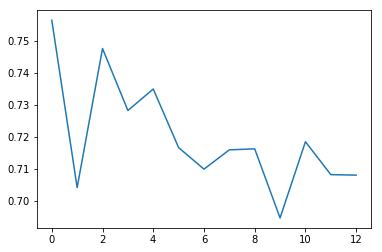

In [14]:
plt.plot(history.history['val_categorical_accuracy'])

In [15]:
plt.savefig(path_to_save_model+'.png')

In [16]:
#fname = 'nikolay_im'

In [17]:
path_to_save_model+'_'+str(j)

NameError: name 'j' is not defined

In [18]:
path_to_save_model+'_'+str(j)

NameError: name 'j' is not defined

In [21]:
fname = datafolder.split('/', 3 )[2]

In [12]:
model = load_model("temp")

In [22]:
res = np.zeros([2,numiter]);

for j in range(numiter):
    model = load_model(path_to_save_model+'_'+str(j))

    eeg_data = test_datas[fname]['eeg_data'].T
    idxs = np.arange(0,eeg_data.shape[1],slice_len)
    num_chunks = idxs.shape[0]

    chunks = np.zeros([num_chunks-1,24,slice_len])
    preds = np.zeros([num_chunks-1,3])

    for i in range(num_chunks-1):
        #print(idxs[i])
        chunk = eeg_data[:,idxs[i]:(idxs[i]+slice_len)].T
        chunks[i,:,:] = chunk.T
        preds[i] = model.predict(chunk[None,:,:,])

    a = np.argmax(preds,axis=1)

    a_bin = np.zeros([3,a.shape[0]])

    a_bin[0,:] = (a == 0)
    a_bin[1,:] = (a == 1)
    a_bin[2,:] = (a == 2)

    true_labels = test_datas[fname]['labels']
    true_labels = true_labels[::slice_len]
    true_labels = true_labels[0:-1]

    true_labels_bin = np.zeros([3,true_labels.shape[0]])

    true_labels_bin[0,:] = (true_labels == 1)
    true_labels_bin[1,:] = (true_labels == 2)
    true_labels_bin[2,:] = (true_labels == 6)

    from sklearn.metrics import roc_auc_score

    score1 = roc_auc_score(true_labels_bin,a_bin)
    #print(score1)

    predsT = preds.T;
    score2 = roc_auc_score(true_labels_bin,predsT)
    print(score1,score2)

    res[0,j] = score1;
    res[1,j] = score2;



0.740384615385 0.786538461538


In [23]:
res_av = np.mean(res,axis = 1)
print(res_av)

[ 0.74038462  0.78653846]


In [286]:
#filename = 'data/ksenia_long_2test'
#filename = 'data/ksenia_long_1'
#[eeg_data, states_labels, sampling_rate, chan_names, chan_numb, samp_numb, states_codes] = open_eeg_mat(filename, centered=False)
#sampling_rate = sampling_rate[0,0]
#eeg_data = butter_bandpass_filter(eeg_data, 0.5, 45, sampling_rate, order=5, how_to_filt = 'simultaneously')

#states_labels = states_labels[0]
#print(states_labels)
#states_labels = states_labels[2000:-2000]
#eeg_data = eeg_data[:,2000:-2000]


In [24]:
eeg_data = test_datas['ksenia_long']['eeg_data'].T
idxs = np.arange(0,eeg_data.shape[1],slice_len)
num_chunks = idxs.shape[0]
num_chunks

261

In [25]:
chunks = np.zeros([num_chunks-1,24,slice_len])
preds = np.zeros([num_chunks-1,3])

for i in range(num_chunks-1):
    #print(idxs[i])
    chunk = eeg_data[:,idxs[i]:(idxs[i]+slice_len)].T
    chunks[i,:,:] = chunk.T
    preds[i] = model.predict(chunk[None,:,:,])


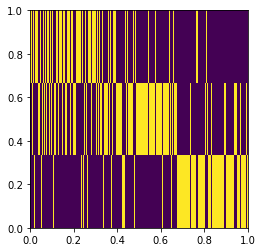

In [26]:
a = np.argmax(preds,axis=1)

a_bin = np.zeros([3,a.shape[0]])

a_bin[0,:] = (a == 0)
a_bin[1,:] = (a == 1)
a_bin[2,:] = (a == 2)
              
plt.imshow(a_bin, extent=[0, 1, 0, 1])

In [27]:
print(preds.shape)
print(a.shape)

true_labels = test_datas['ksenia_long']['labels']
true_labels = true_labels[::slice_len]
true_labels = true_labels[0:-1]
print(true_labels.shape)

true_labels_bin = np.zeros([3,true_labels.shape[0]])
print(true_labels_bin.shape)

true_labels_bin[0,:] = (true_labels == 1)
true_labels_bin[1,:] = (true_labels == 2)
true_labels_bin[2,:] = (true_labels == 6)


(260, 3)
(260,)
(260,)
(3, 260)


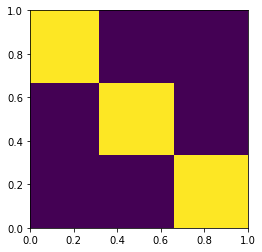

In [28]:
plt.imshow(true_labels_bin, extent=[0, 1, 0, 1])

In [29]:
from sklearn.metrics import roc_auc_score

score1 = roc_auc_score(true_labels_bin,a_bin)
print(score1)

predsT = preds.T;
score2 = roc_auc_score(true_labels_bin,predsT)
print(score2)

0.740384615385
0.786538461538


In [30]:
print(true_labels_bin.shape)
print(a_bin.shape)

(3, 260)
(3, 260)


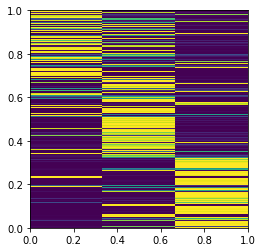

In [31]:
plt.imshow(preds, extent=[0, 1, 0, 1])

In [32]:
import numpy as np
from matplotlib import pyplot as plt

from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input

from vis.utils import utils
#from vis.utils.vggnet import VGG16
from vis.visualization import *



In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 250, 24)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 250, 10)           2890      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                220       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout_2 (Dropout)          (None, 20)                0         
__________

In [34]:
from scipy.signal import butter, lfilter

def butter_bandpass_m(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter_m(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [59]:
layer_name = 'dense_3'
numtops = 20

tops = np.zeros([numtops,21])

for j in range(numtops):

    layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

    idx = 0;
    img = visualize_class_activation(model, layer_idx, filter_indices=idx, max_iter=10000)

    from mne.viz import plot_topomap
    import numpy as np
    from scipy.io import loadmat

    img = butter_bandpass_filter_m(img.T,10,12,250,5).T
    img_sum = np.sum(img,axis = 0)
    testmat = loadmat('chanlocs')

    ifvis = testmat['ifvis']
    ifvis = ifvis[0]
    ifvis = (ifvis == 1)

    chanlocs = testmat['chanlocs_xy'].T

    chanlocs_m = chanlocs[:,[-1,-2]]
    chanlocs_m[:,-2] = -chanlocs_m[:,-2]

    img_sum_vis = img_sum[ifvis]

    tops[j,:] = img_sum_vis


KeyboardInterrupt: 

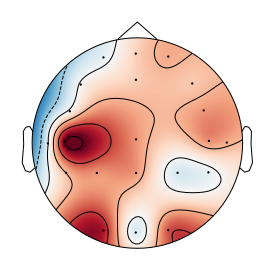

(<matplotlib.image.AxesImage at 0xdd7dfb4c88>,
 <matplotlib.contour.QuadContourSet at 0xdd7ceeb278>)

In [60]:
plot_topomap(img_sum_vis,chnames_pos)

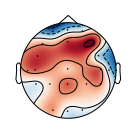

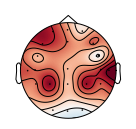

ValueError: num must be 1 <= num <= 2, not 3

In [69]:
plt.figure(1)


for j in range(numtops):
    plt.subplot(2, 1, j+1);
    plot_topomap(tops[j,:],chnames_pos);

In [ ]:
plot_topomap(img_sum_vis,chanlocs_m)

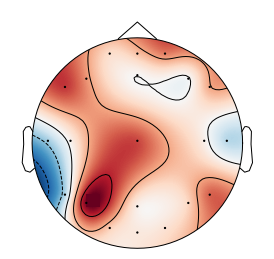

(<matplotlib.image.AxesImage at 0xdd59cc68d0>,
 <matplotlib.contour.QuadContourSet at 0xdd59d5c4a8>)

In [38]:
plot_topomap(img_sum_vis,chanlocs_m)

In [39]:
from mne.viz import plot_topomap 
from mne.channels import read_montage


In [40]:
def ch_names_to_2d_pos(list_of_ch_names, kind='standard_1005'):
    montage = read_montage(kind) 
    upper_list_of_ch_names = [ch.upper() for ch in list_of_ch_names] 
    upper_montage_ch_names = [ch.upper() for ch in montage.ch_names] 
    indices = [upper_montage_ch_names.index(ch) for ch in upper_list_of_ch_names if ch in upper_montage_ch_names] 
    if len(list(indices)) < len(list_of_ch_names): 
        raise IndexError('Channels {} not found'.format( 
        set(upper_list_of_ch_names).difference(set(np.array(upper_montage_ch_names)[indices])) 
        )) 
    pos = montage.pos[indices, :2] 
    return np.array(pos)

In [41]:
chnames_file = loadmat('chan_names_moved')
chnames_moved = chnames_file['chnames_mod']
chnames_moved = chnames_moved[:,0]
chnames_moved = chnames_moved.tolist()
for i in range(len(chnames_moved)):
    chnames_moved[i] = chnames_moved[i][0]

In [45]:
chnames_moved

['CP3',
 'C5',
 'F3',
 'FC3',
 'C3',
 'CP1',
 'FP1',
 'FPZ',
 'A1',
 'O1',
 'CZ',
 'OZ',
 'FZ',
 'CPZ',
 'O2',
 'A2',
 'FP2',
 'CP2',
 'C4',
 'FC4',
 'F4',
 'C6',
 'CP4',
 'AUX']

In [46]:
chnames_pos

NameError: name 'chnames_pos' is not defined

In [47]:
ch_idxs = np.ones([len(chnames_moved),],dtype=bool)
ch_idxs[8] = 0
ch_idxs[15] = 0
ch_idxs[-1] = 0

print(ch_idxs)

[ True  True  True  True  True  True  True  True False  True  True  True
  True  True  True False  True  True  True  True  True  True  True False]


In [48]:
np.array(chnames_moved)

array(['CP3', 'C5', 'F3', 'FC3', 'C3', 'CP1', 'FP1', 'FPZ', 'A1', 'O1',
       'CZ', 'OZ', 'FZ', 'CPZ', 'O2', 'A2', 'FP2', 'CP2', 'C4', 'FC4',
       'F4', 'C6', 'CP4', 'AUX'], 
      dtype='<U3')

In [49]:
np.array(chnames_moved)[ch_idxs]

array(['CP3', 'C5', 'F3', 'FC3', 'C3', 'CP1', 'FP1', 'FPZ', 'O1', 'CZ',
       'OZ', 'FZ', 'CPZ', 'O2', 'FP2', 'CP2', 'C4', 'FC4', 'F4', 'C6',
       'CP4'], 
      dtype='<U3')

In [50]:
np.array(chnames_moved)[ch_idxs].tolist()

['CP3',
 'C5',
 'F3',
 'FC3',
 'C3',
 'CP1',
 'FP1',
 'FPZ',
 'O1',
 'CZ',
 'OZ',
 'FZ',
 'CPZ',
 'O2',
 'FP2',
 'CP2',
 'C4',
 'FC4',
 'F4',
 'C6',
 'CP4']

In [51]:
chnames_pos = ch_names_to_2d_pos(np.array(chnames_moved)[ch_idxs].tolist())

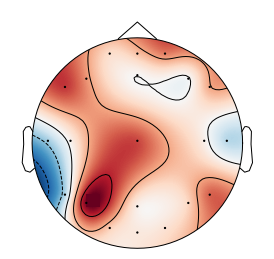

(<matplotlib.image.AxesImage at 0xdd59d5cbe0>,
 <matplotlib.contour.QuadContourSet at 0xdd59ea8a20>)

In [52]:
plot_topomap(img_sum_vis,chanlocs_m)

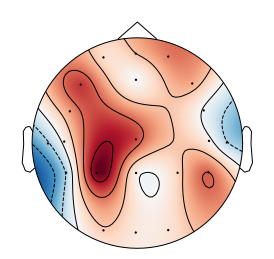

(<matplotlib.image.AxesImage at 0xdd59f7e8d0>,
 <matplotlib.contour.QuadContourSet at 0xdd59fd24a8>)

In [53]:
plot_topomap(img_sum_vis,chnames_pos)